In [1]:
"""
Demonstrate the effect of autapse parameters on the AHP waveform after a spike.

We could maybe correlate autapse variables to degree of this effect - e.g. the 
degree of divergence from the non-autaptic AHP.

"""

'\nDemonstrate the effect of autapse parameters on the AHP waveform after a spike.\n\nWe could maybe correlate autapse variables to degree of this effect - e.g. the \ndegree of divergence from the non-autaptic AHP.\n\n'

In [2]:
# append AQUA directory to sys.path
import sys
import os
sys.path.append("..\\") # parent directory
from AQUA_general import AQUA
from batchAQUA_general import batchAQUA
from plotting_functions import *

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import pickle
from tqdm import tqdm   # for a progress bar
import seaborn as sns
sns.set_theme(style = "white")

# local imports
import CLI
import CF
from functions import *

In [3]:
def create_AHP(params, base_current, x_ini, T = 0.2, dt = 0.1,  f_ref = 150, e_ref = 0.2, tau_ref = 0.0):
    """
    Generate a plot to show how the AHP is affected by different autapse parameters
    Args:
        params:     list of dictionaries
    Returns:
        fig, ax     matplotlib plot

    """

    N_iter = int(1000*T/dt)


    N_neurons = np.shape(params)[0]

    I_inj = base_current * np.ones((N_neurons, N_iter))

    # initial conditions
    x_start = np.full((N_neurons, 3), fill_value = x_ini)
    t_start = np.zeros(N_neurons)

    #define batch
    batch = batchAQUA(params)
    batch.Initialise(x_start, t_start)

    X, Time, spikes = batch.update_batch(dt, N_iter, I_inj)

    start_time = spikes[0, 0] - 100     # the time to start each plot.
    start_idx = int(start_time/dt)

    # first compare across different f - e and tau are constant
    param_df = pd.DataFrame(params)
    sub_df = param_df[(param_df['e'] == e_ref) & (param_df['tau']== tau_ref)].sort_values(by=['f'])
    idx = sub_df.index
    cmap = 'bwr'

    fig, ax = plot_AHP(X, Time, sub_df, idx, 'f', start_idx, cmap)
    fig.suptitle("AHP with different autapses ordered \nby peak autaptic current", fontsize = 20)
    ax.set_title(f"e: {e_ref} /ms, tau: {tau_ref} ms", fontsize = 16)
    plt.savefig(f"AHP\\{params[0]["name"]}_f.png")

    # compare different e - f and tau are constant
    param_df = pd.DataFrame(params)
    sub_df = param_df[(param_df['f'] == f_ref) & (param_df['tau']== tau_ref)].sort_values(by=['e'])
    idx = sub_df.index
    cmap = 'plasma'

    fig, ax = plot_AHP(X, Time, sub_df, idx, 'e', start_idx, cmap)
    fig.suptitle("AHP with different autapses ordered \nby autaptic decay constant", fontsize = 20)
    ax.set_title(f"f: {f_ref} pA, tau: {tau_ref} ms", fontsize = 16)
    plt.savefig(f"AHP\\{params[0]["name"]}_e.png")

    # compare different tau - f and e are constant
    param_df = pd.DataFrame(params)
    sub_df = param_df[(param_df['f'] == f_ref) & (param_df['e']== e_ref)].sort_values(by=['tau'])
    idx = sub_df.index
    cmap = 'YlOrRd'

    fig, ax = plot_AHP(X, Time, sub_df, idx, 'tau', start_idx, cmap)
    fig.suptitle("AHP with different autapses ordered \nby autaptic time delay", fontsize = 20)
    ax.set_title(f"f: {f_ref} pA, e: {e_ref} /ms", fontsize = 16)
    plt.savefig(f"AHP\\{params[0]["name"]}_tau.png")
    


def plot_AHP(X, T, sub_df, indices, param_name, start_idx, cmap):

    fig, ax = plt.subplots(1, 1, figsize = (8, 8))
    plot_units = {'f': 'pA', 'e': '/ms', 'tau': 'ms'}
    arr = sub_df[param_name].values

    # get discrete values of colormap
    cont_cmap = plt.colormaps[cmap]
    if param_name == 'f':
        x_min = sub_df['f'].min()
        x_max = sub_df['f'].max()
        center = 0.0
        norm = colors.TwoSlopeNorm(vmin = x_min, vmax = x_max, vcenter = center)
        norm_vals = norm(sub_df[param_name])
        color_codes = cont_cmap(norm_vals)
    else:
        color_codes = cont_cmap(np.linspace(0, 1, len(indices)))

    for n, i in enumerate(indices):
        ax.plot(T[i, :],X[i, 0, :], color = color_codes[n], label = f"{np.round(arr[n], 2)} {plot_units[param_name]}")

    # plot non-autaptic neuron
    ax.plot(T[0, :], X[0, 0, :], c = 'black', label = 'no autapse')
    ax.set_xlabel("Time [ms]", fontsize = 16)
    ax.set_ylabel("Membrane Potential [mV]", fontsize = 16)
    plt.legend()

    return fig, ax

    

In [4]:
# param
RS = {'name': 'RS_resonator', 'C': 100, 'k': 0.7, 'v_r': -60, 'v_t': -40, 'v_peak': 35,
     'a': 0.03, 'b': 5, 'c': -50, 'd': 100, 'e': 0.0, 'f': 0.0, 'tau': 0.0}    # Class 1

f_vals = np.arange(-250, 251, 50)
idx_0 = np.argwhere(f_vals == 0)
f_vals = f_vals[np.r_[0:idx_0, idx_0+1:len(f_vals)]]
e_vals = np.arange(0.1, 0.5, 0.1)
tau_vals = np.array([0, 0.5, 2, 4])

params = []
params.append(RS)
for f in f_vals:
    for e in e_vals:
        for tau in tau_vals:
            temp_dict = RS.copy()
            temp_dict['f'] = f
            temp_dict['e'] = e
            temp_dict['tau'] = tau
            params.append(temp_dict)

# NOW params contains all the parameter values we need.
print(len(params))

threshold, x_ini = find_threshold(params[0], np.linspace(0, 500, 100), 2, 0.1)
base_current = threshold + 25 # + 10 for integrator

161


100%|██████████| 19999/19999 [00:03<00:00, 5811.36it/s]


100%|██████████| 1999/1999 [00:00<00:00, 5112.37it/s]


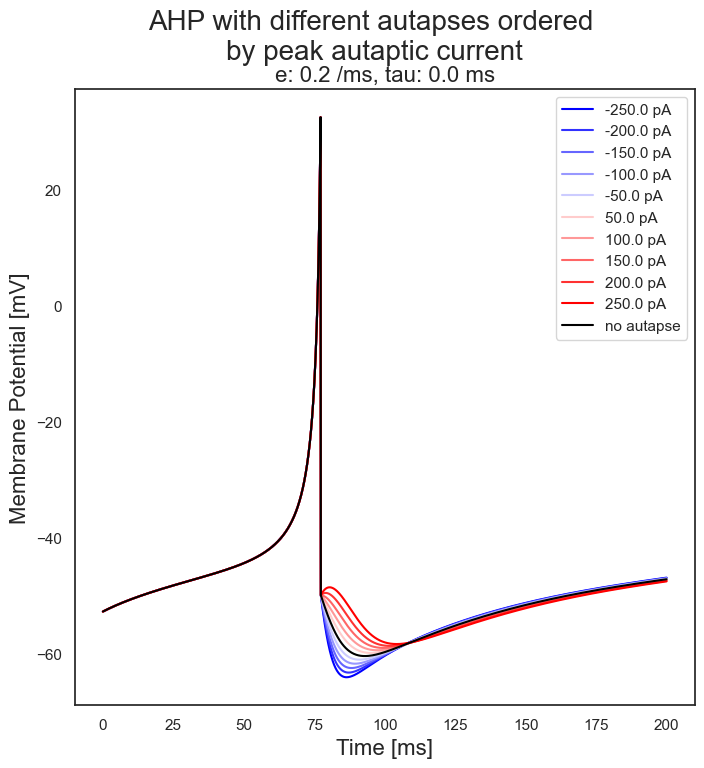

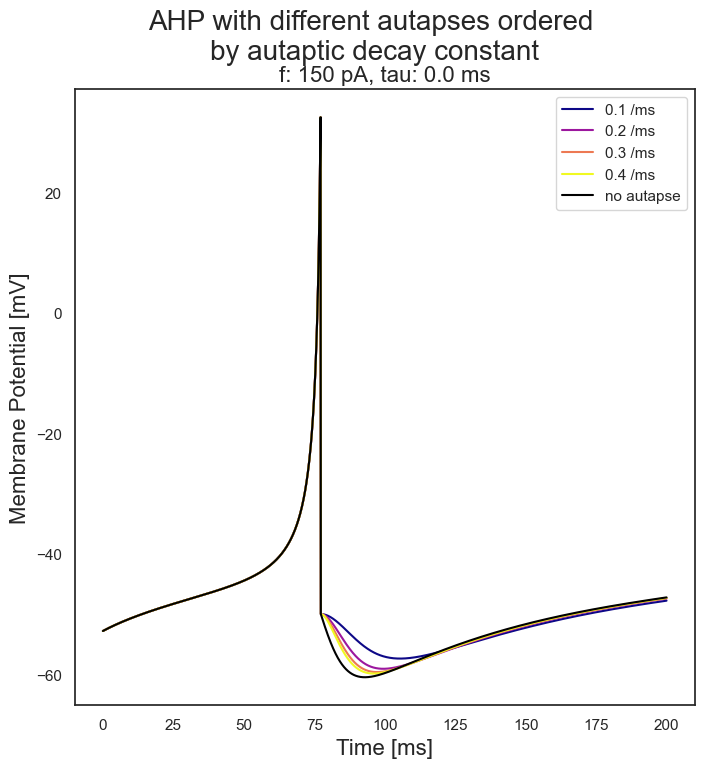

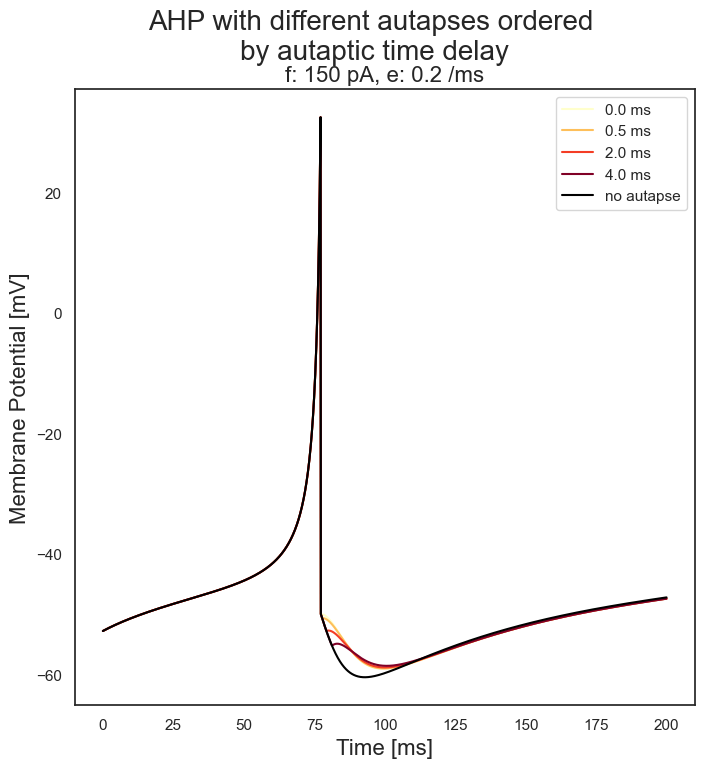

In [5]:
create_AHP(params, base_current, x_ini)

100%|██████████| 19999/19999 [00:03<00:00, 5756.95it/s]


(2, 3)


100%|██████████| 14999/14999 [00:02<00:00, 6524.25it/s]


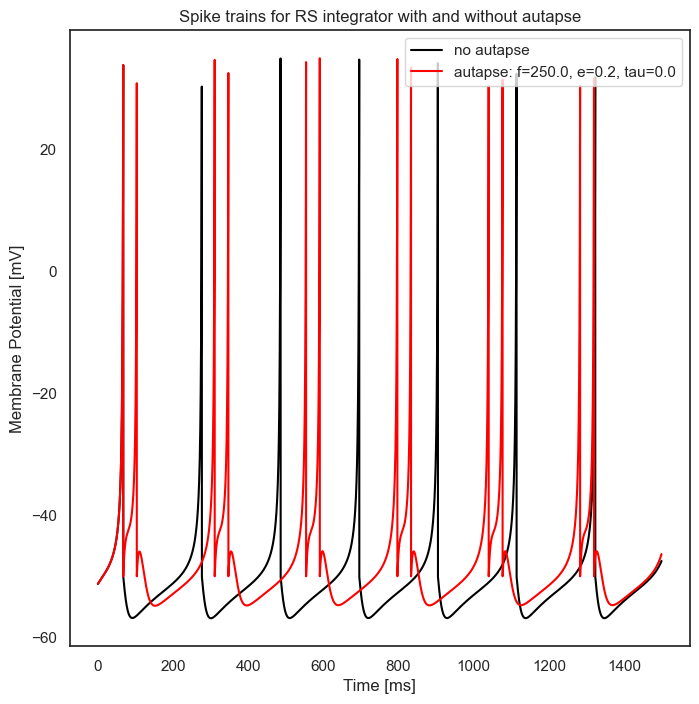

In [6]:
# plot only RS_integrator with 250 pA, 0.2 and tau = 0
params = [{'name': 'RS_integrator', 'C': 100, 'k': 0.7, 'v_r': -60, 'v_t': -40, 'v_peak': 35,
            'a': 0.03, 'b': -2, 'c': -50, 'd': 100, 'e': 0., 'f': 0.0, 'tau': 0.0},
          {'name': 'RS_integrator', 'C': 100, 'k': 0.7, 'v_r': -60, 'v_t': -40, 'v_peak': 35,
          'a': 0.03, 'b': -2, 'c': -50, 'd': 100, 'e': 0.2, 'f': 250.0, 'tau': 0.0}]


threshold, x_ini = find_threshold(params[0], np.linspace(0, 500, 100), 2, 0.1)
baseline = threshold + 10   # slightly above firing

T = 1.5     # s
dt = 0.1    # ms
N_iter = int(1000*T/dt)

N_neurons = len(params)
I_inj = baseline * np.ones((N_neurons, N_iter))

# initial conditions
x_start = np.full(shape = (N_neurons, 3), fill_value = x_ini)
print(np.shape(x_start))
t_start = np.zeros((N_neurons))


#define batch
batch = batchAQUA(params)
batch.Initialise(x_start, t_start)


X, Time, spikes = batch.update_batch(dt, N_iter, I_inj)

fig, ax = plt.subplots(1, 1, figsize = (8, 8))
ax.plot(Time[0, :], X[0, 0, :], c = 'black', label = "no autapse")
ax.plot(Time[1, :], X[1, 0, :], c = 'red', label = f"autapse: f={params[1]['f']}, e={params[1]['e']}, tau={params[1]['tau']}")

ax.set_title("Spike trains for RS integrator with and without autapse")
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Membrane Potential [mV]")
plt.legend()

plt.savefig(f"AHP\\RS_to_IB_transition.png")

In [10]:
# param
FS = {'name': 'FS', 'C': 20, 'k': 1, 'v_r': -55, 'v_t': -40, 'v_peak': 25,
        'a': 0.2, 'b': -2, 'c': -45, 'd': 0, 'e': 0., 'f': 0., 'tau': 0.}

f_vals = np.arange(-500, 251, 50)
idx_0 = np.argwhere(f_vals == 0)
f_vals = f_vals[np.r_[0:idx_0, idx_0+1:len(f_vals)]]
e_vals = np.arange(0.1, 0.5, 0.1)
tau_vals = np.array([0, 0.5, 2, 4])

params = []
params.append(FS)
for f in f_vals:
    for e in e_vals:
        for tau in tau_vals:
            temp_dict = FS.copy()
            temp_dict['f'] = f
            temp_dict['e'] = e
            temp_dict['tau'] = tau
            params.append(temp_dict)

# NOW params contains all the parameter values we need.
print(len(params))

threshold, x_ini = find_threshold(params[0], np.linspace(0, 500, 100), 2, 0.1)
base_current = threshold + 10 # + 10 for integrator



241


100%|██████████| 19999/19999 [00:03<00:00, 5912.86it/s]


100%|██████████| 999/999 [00:00<00:00, 4389.67it/s]


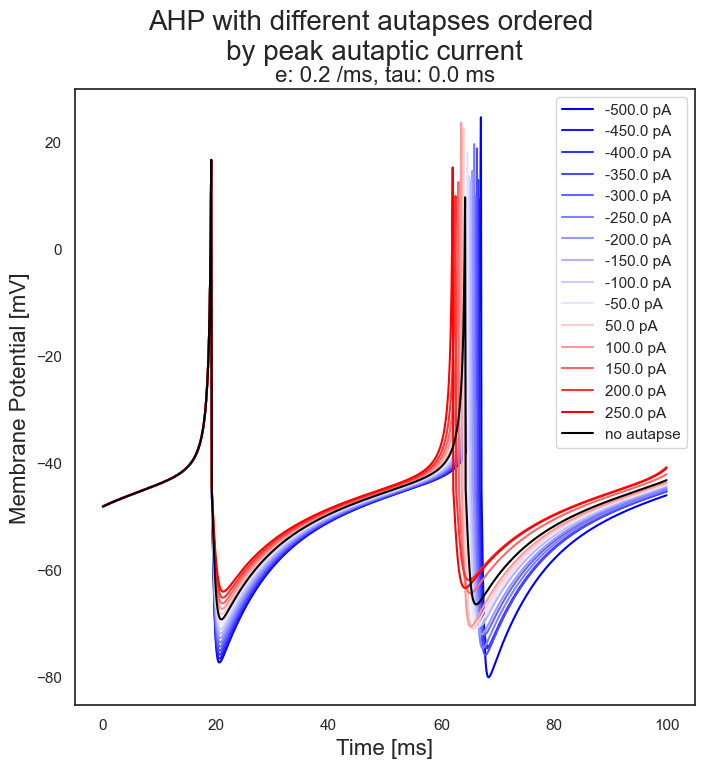

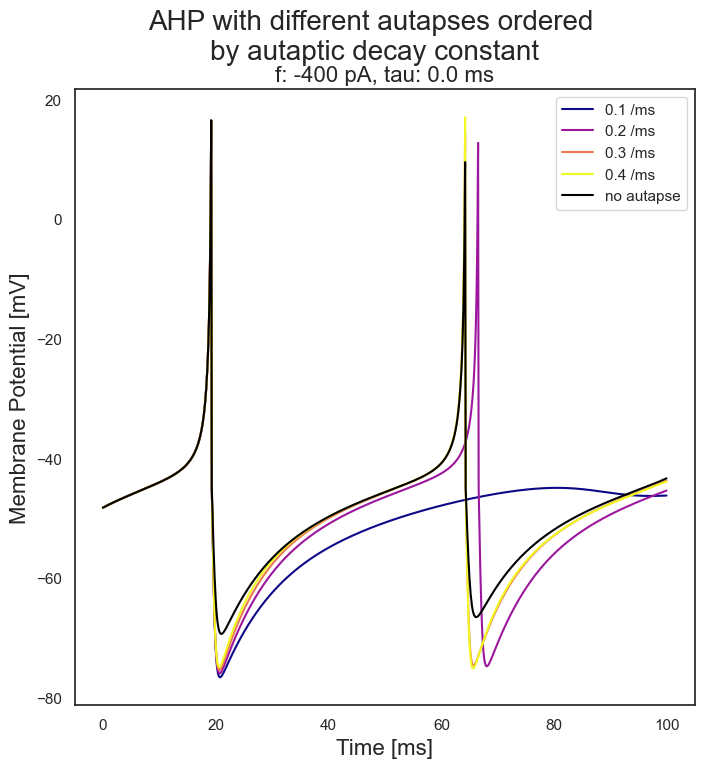

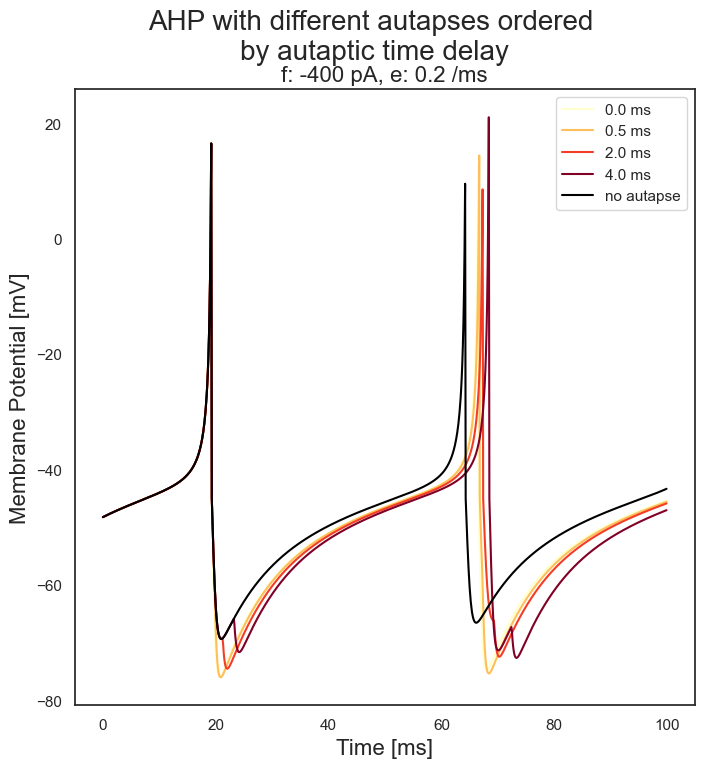

In [12]:
create_AHP(params, base_current, x_ini, T = 0.1, dt = 0.1, f_ref = -400, e_ref = 0.2, tau_ref = 0.0)

100%|██████████| 19999/19999 [00:03<00:00, 5291.99it/s]


(2, 3)


100%|██████████| 99999/99999 [00:17<00:00, 5852.43it/s]


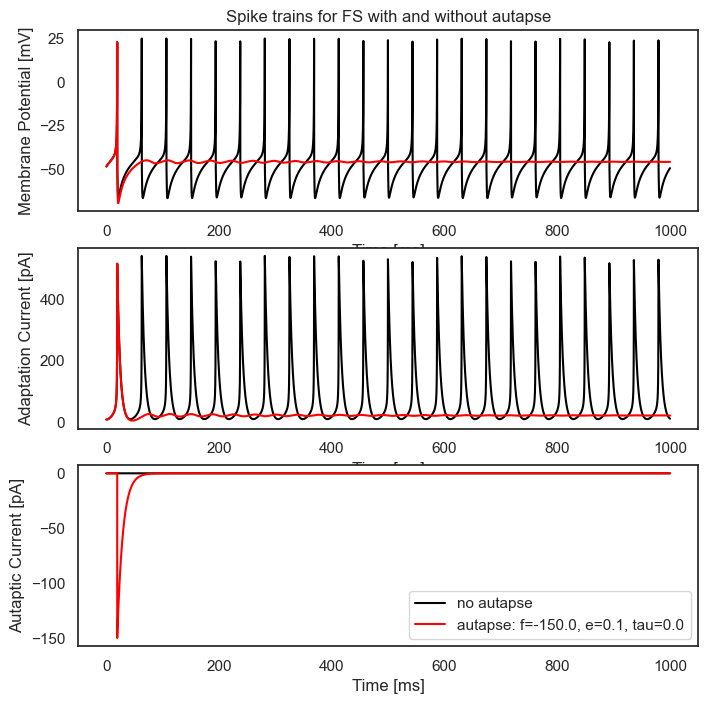

In [9]:
# plot only RS_integrator with 250 pA, 0.2 and tau = 0
params = [{'name': 'FS', 'C': 20, 'k': 1, 'v_r': -55, 'v_t': -40, 'v_peak': 25,
            'a': 0.2, 'b': -2, 'c': -45, 'd': 0, 'e': 0., 'f': 0., 'tau': 0.},
          {'name': 'FS', 'C': 20, 'k': 1, 'v_r': -55, 'v_t': -40, 'v_peak': 25,
            'a': 0.2, 'b': -2, 'c': -45, 'd': 0, 'e': 0.1, 'f': -150., 'tau': 0.}]


threshold, x_ini = find_threshold(params[0], np.linspace(0, 500, 100), 2, 0.1)
baseline = threshold + 10   # slightly above firing

T = 1.0     # s
dt = 0.01    # ms
N_iter = int(1000*T/dt)

N_neurons = len(params)
I_inj = baseline * np.ones((N_neurons, N_iter))

# initial conditions
x_start = np.full(shape = (N_neurons, 3), fill_value = x_ini)
print(np.shape(x_start))
t_start = np.zeros((N_neurons))


#define batch
batch = batchAQUA(params)
batch.Initialise(x_start, t_start)


X, Time, spikes = batch.update_batch(dt, N_iter, I_inj)

fig, ax = plt.subplots(3, 1, figsize = (8, 8))
ax[0].plot(Time[0, :], X[0, 0, :], c = 'black', label = "no autapse")
ax[0].plot(Time[1, :], X[1, 0, :], c = 'red', label = f"autapse: f={params[1]['f']}, e={params[1]['e']}, tau={params[1]['tau']}")

ax[1].plot(Time[0, :], X[0, 1, :], c = 'black', label = "no autapse")
ax[1].plot(Time[1, :], X[1, 1, :], c = 'red', label = f"autapse: f={params[1]['f']}, e={params[1]['e']}, tau={params[1]['tau']}")

ax[2].plot(Time[0, :], X[0, 2, :], c = 'black', label = "no autapse")
ax[2].plot(Time[1, :], X[1, 2, :], c = 'red', label = f"autapse: f={params[1]['f']}, e={params[1]['e']}, tau={params[1]['tau']}")

ax[0].set_title("Spike trains for FS with and without autapse")
ax[0].set_xlabel("Time [ms]")
ax[0].set_ylabel("Membrane Potential [mV]")

ax[1].set_xlabel("Time [ms]")
ax[1].set_ylabel("Adaptation Current [pA]")

ax[2].set_xlabel("Time [ms]")
ax[2].set_ylabel("Autaptic Current [pA]")

plt.legend()

plt.savefig(f"AHP\\FS_transition.png")